## Going10 도로 영역을 찾자 - 세그멘테이션 모델 만들기

Sementic Segmentation (시멘틱 세그멘테이션)을 이용해서 자율주행차량이 주행해야할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보는 시간을 가진다.


### 실습목표
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.


### 학습내용
1. 시맨틱 세그멘테이션 데이터셋
2. 시맨틱 세그멘테이션 모델
3. 시맨틱 세그멘테이션 모델 시각화


## 10-2 시맨틱 세그멘테이션 데이터셋

### 이미지, 데이터 가져오기

먼저 시멘틱 세그멘테이션으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱해야한다. 아래 링크를 통해 물체검출(object detection)으로 사용했던 `KITTI 데이터셋의 세그멘테이션 데이터`를 다운로드한다.

http://www.cvlibs.net/datasets/kitti/eval_semantics.php

세그멘테이션 데이터는 이미지 형태의 라벨로 되어있다.

### 데이터 로더(data loader) 만들기

이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만든다. 로더는 입력값 `(224, 224)`, 출력값 `(224, 224)` 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야한다.


이때 데이터 로더에 `augmentation`을 적용한다. 또 학습셋의 일정량을 `검증 데이터셋(validation dataset)`으로 활용할 수 있어야한다.

참고 자료
- https://hwiyong.tistory.com/241
- https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac

만든 후 직접 데이터셋이 잘 파싱되어 나오는지 확인해야한다. 그 이유는 데이터셋에 오류가 없어야 성능이 안나오더라도 문제를 찾아내기 쉽기 때문이다.





In [42]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


Albumentation의 사용법을 간단히 알아본다. 아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게하는 `Compose()`의 활용예이다. imgaug의 `Sometimes()`와 유사한 기능이다.

In [43]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

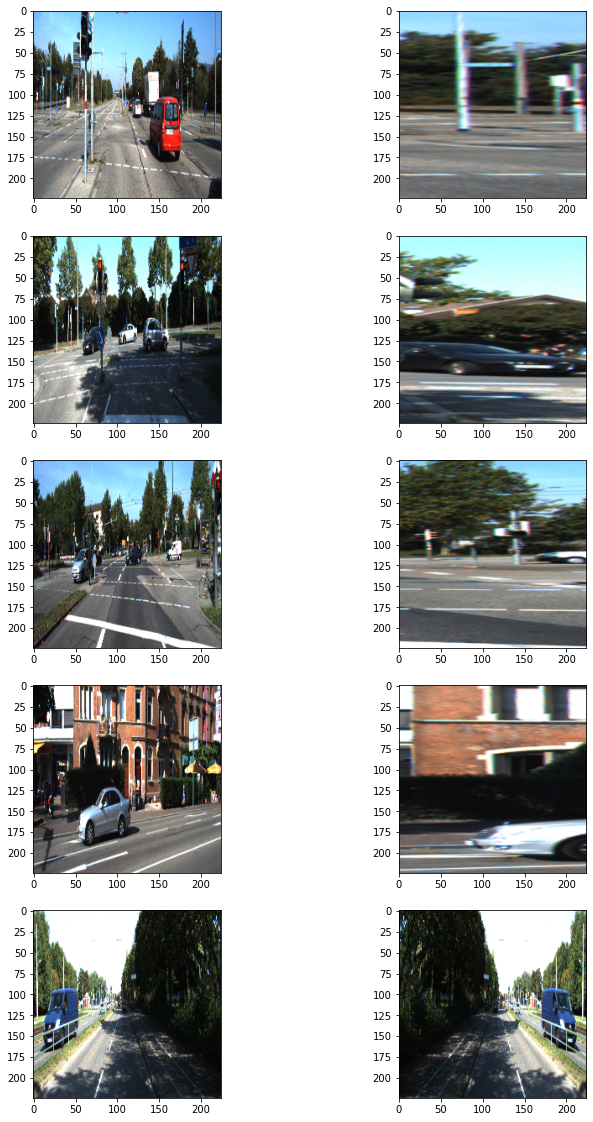

In [44]:
dir_path = '/content/drive/MyDrive/data_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

데이터셋을 구성한다. tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해본다.

In [45]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [46]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 10-3 시맨틱 세그멘테이션 모델

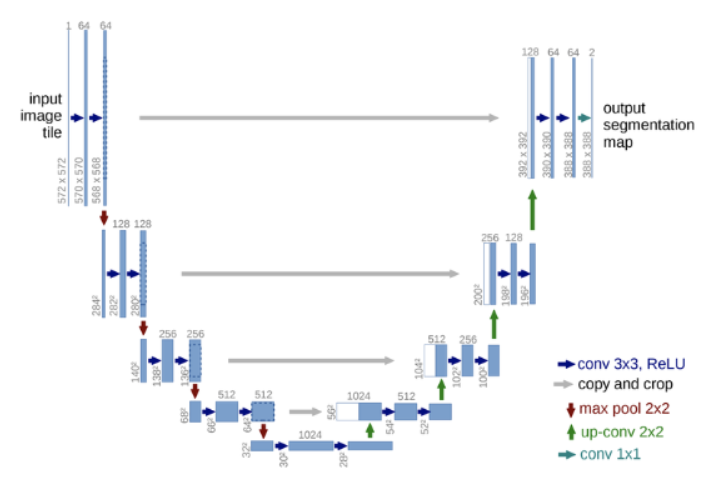

### 모델 구조 만들기

세그멘테이션 모델 중 구조상 비교적 구현이 단순한 `U-Net`을 구현해본다. 

입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만든다.

필요에 따라 Dropout 등의 다른 레이어를 적용해본다.
- `Conv2D`, `Conv2DTranspose`, `MaxPooling2D`, `concatenate`

In [47]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습하기

위에서 만든 데이터셋과 학습을 한다. 

In [48]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 16s 628ms/step - loss: 0.6875 - val_loss: 0.6781
Epoch 2/100
11/11 [==============================] - 7s 599ms/step - loss: 0.5531 - val_loss: 0.0873
Epoch 3/100
11/11 [==============================] - 6s 586ms/step - loss: 0.0386 - val_loss: 0.0372
Epoch 4/100
11/11 [==============================] - 6s 583ms/step - loss: 0.0335 - val_loss: 0.0363
Epoch 5/100
11/11 [==============================] - 6s 582ms/step - loss: 0.0309 - val_loss: 0.0292
Epoch 6/100
11/11 [==============================] - 6s 585ms/step - loss: 0.0295 - val_loss: 0.0331
Epoch 7/100
11/11 [==============================] - 6s 584ms/step - loss: 0.0263 - val_loss: 0.0245
Epoch 8/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0223 - val_loss: 0.0318
Epoch 9/100
11/11 [==============================] - 6s 590ms/step - loss: 0.0358 - val_loss: 0.0290
Epoch 10/100
11/11 [==============================] - 7s 594ms/step - loss: 0.0270 - val_l

## 10-4 시맨틱 세그멘테이션 모델 시각화

In [49]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어주세요!

이때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 `오버레이(overray)` 해 주세요. PIL 패키지를 사용하신다면 `Image.blend`를 활용하실 수 있습니다.

`get_output`이라는 이름의 함수로 만들어 주세요.


In [50]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

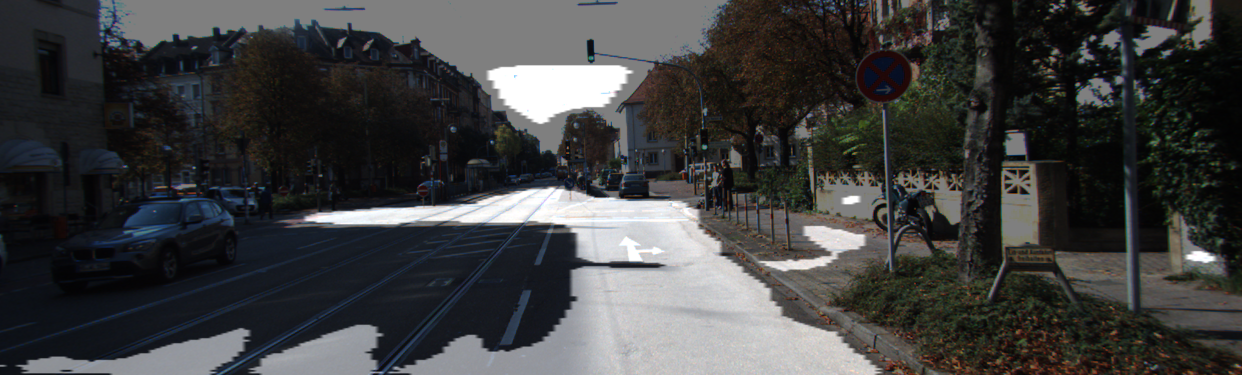

In [51]:
# 위에서 작성한 함수를 이용해서 시각화를 해본다.
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다. IoU를 계산하는 방법은 지난 시간에 소개한 바 있으므로 해당 내용을 활용하여 구현해 보겠습니다.

IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 각각을 `prediction`, `target`이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다. 위에 구현했던 `get_output`을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

## 10-5 프로젝트 : 개선된 U-Net 모델 만들기

### Step 1. KITTI 데이터셋 수집과 구축


In [14]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.8.0
1.21.5
7.1.2
0.18.3
0.1.12


In [15]:
#필요한 라이브러리를 로드합니다. 
import os
import math

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input, merge, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout
from keras import regularizers

import numpy as np

print('슝=3')

슝=3


In [16]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

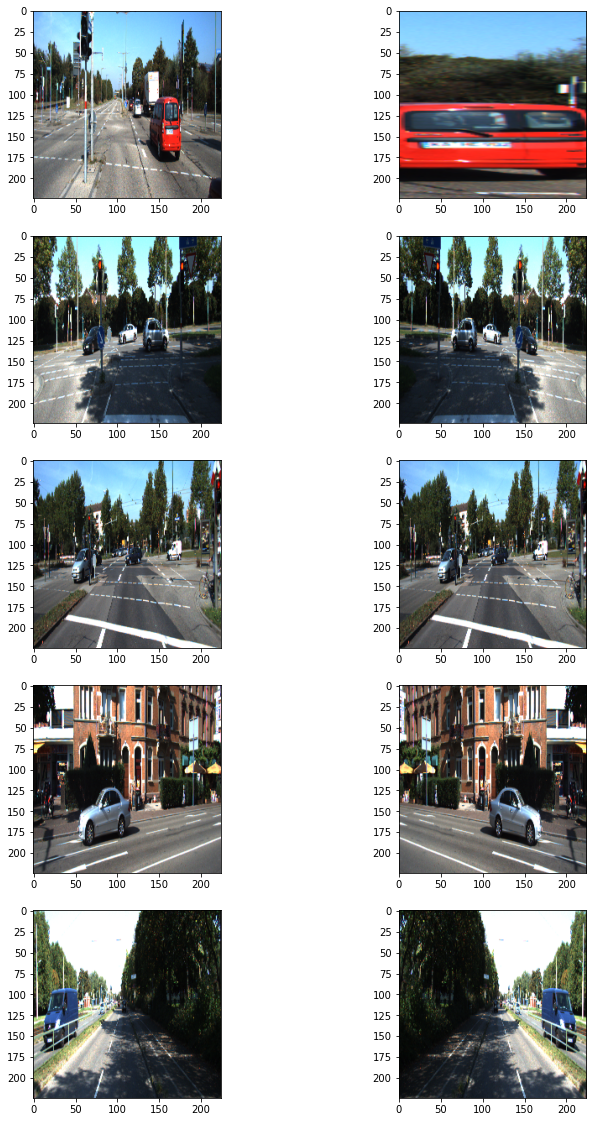

In [17]:
dir_path = '/content/drive/MyDrive/data_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [18]:
class KittiGenerator(tf.keras.utils.Sequence):

  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    self.data = self.load_dataset()

  def load_dataset(self):
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [19]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델의 구현

In [20]:
def UNetPlusPlus(input_shape=(224, 224, 3), num_class=1, deep_supervision=False, batch_size=4):
    inputs = Input(input_shape)
    
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5_1)


    up1_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)

    up2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2)
    
    up3_2 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], axis = 3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_2)

    up4_2 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], axis = 3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_2)


    up1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)

    up2_3 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis = 3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_3)

    up3_3 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis = 3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_3)
    

    up1_4 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis = 3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_4)


    up2_4 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv3_3))
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis = 3)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_4)

    
    up1_5 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv2_4))
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis = 3)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_5)
 
    output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_2)
    output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_3)
    output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_4)
    output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=inputs, outputs=[output_1,
                                               output_2,
                                               output_3,
                                               output_4])
    else:
        model = Model(inputs=inputs, outputs=[output_4])

    return model

In [21]:
model_plusplus = UNetPlusPlus()
model_plusplus.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [22]:
# deep_supervision
UNetPlusPlus_vision = UNetPlusPlus(deep_supervision=True)
UNetPlusPlus_vision.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 112, 112, 64  0          ['conv2d_17[0][0]']              
                                )                                                           

In [23]:
model_path = '/content/drive/MyDrive/data_segmentation/seg_model_unetplusplus.h5'

# model = model_plusplus()
model_plusplus.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
model_plusplus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_plusplus.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 34s 930ms/step - loss: 0.6313 - val_loss: 0.4651
Epoch 2/100
22/22 [==============================] - 16s 706ms/step - loss: 0.1289 - val_loss: 0.0591
Epoch 3/100
22/22 [==============================] - 15s 697ms/step - loss: 0.0651 - val_loss: 0.0623
Epoch 4/100
22/22 [==============================] - 15s 698ms/step - loss: 0.0602 - val_loss: 0.0628
Epoch 5/100
22/22 [==============================] - 15s 705ms/step - loss: 0.0572 - val_loss: 0.0615
Epoch 6/100
22/22 [==============================] - 16s 715ms/step - loss: 0.0539 - val_loss: 0.0560
Epoch 7/100
22/22 [==============================] - 16s 706ms/step - loss: 0.0515 - val_loss: 0.0569
Epoch 8/100
22/22 [==============================] - 16s 712ms/step - loss: 0.0467 - val_loss: 0.0501
Epoch 9/100
22/22 [==============================] - 16s 720ms/step - loss: 0.0536 - val_loss: 0.0613
Epoch 10/100
22/22 [==============================] - 16s 736ms/step - loss: 0.047

In [24]:
def get_output(model, preproc, image_path, output_path):

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255 ##0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()

    return output

In [25]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [26]:
def get_output_iou(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [54]:
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

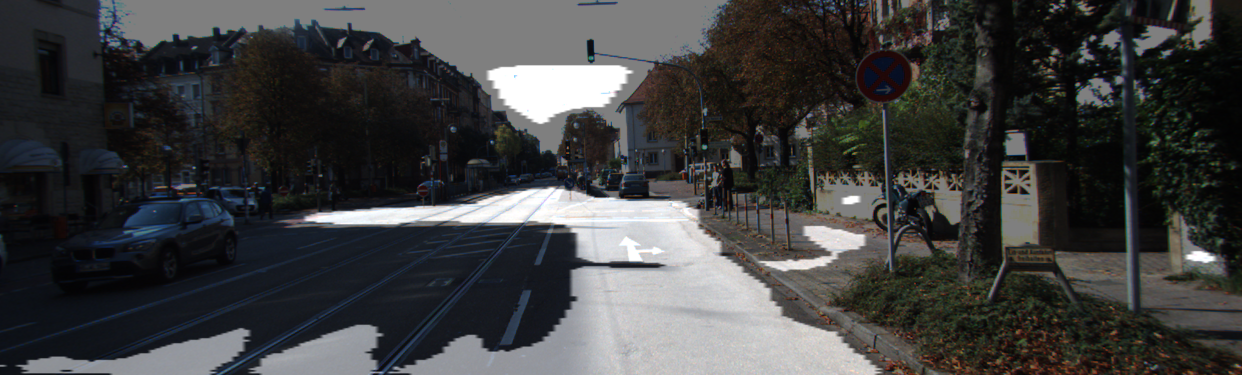

In [55]:
i = 1    # i값을 바꾸면 테스트용 파일이 변경됨
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [56]:
output, prediction, target = get_output_iou(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

In [38]:
unetplus_model_path = '/content/drive/MyDrive/data_segmentation/seg_model_unetplusplus.h5'
unetplus_model = tf.keras.models.load_model(unetplus_model_path)

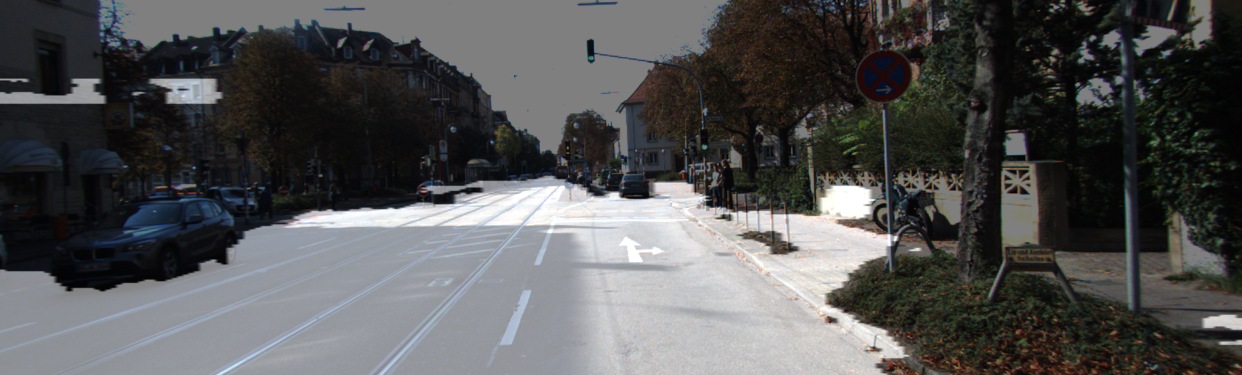

In [39]:
i = 1
get_output(
     unetplus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [40]:
output, prediction, target = get_output_iou(
     unetplus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.840549


0.840548534552299

In [57]:
# U-Net IoU
unet = []
for i in range(30):
    output, prediction, target = get_output_iou(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

    unet.append(calculate_iou_score(target, prediction))

IoU : 0.169192
IoU : 0.419641
IoU : 0.584087
IoU : 0.571212
IoU : 0.560296
IoU : 0.647032
IoU : 0.096767
IoU : 0.682226
IoU : 0.382736
IoU : 0.417902
IoU : 0.396688
IoU : 0.339661
IoU : 0.312324
IoU : 0.427770
IoU : 0.483619
IoU : 0.633674
IoU : 0.650405
IoU : 0.620941
IoU : 0.238317
IoU : 0.496165
IoU : 0.398642
IoU : 0.206589
IoU : 0.510595
IoU : 0.748359
IoU : 0.612990
IoU : 0.589673
IoU : 0.526770
IoU : 0.325911
IoU : 0.338556
IoU : 0.285741


In [58]:
# U-Net++ IoU
unet_plus = []
for i in range(30):
    output, prediction, target = get_output_iou(
     unetplus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

    unet_plus.append(calculate_iou_score(target, prediction))

IoU : 0.942756
IoU : 0.840549
IoU : 0.615061
IoU : 0.524643
IoU : 0.579164
IoU : 0.603149
IoU : 0.593503
IoU : 0.789076
IoU : 0.812688
IoU : 0.703718
IoU : 0.708435
IoU : 0.702652
IoU : 0.616679
IoU : 0.815860
IoU : 0.867455
IoU : 0.857418
IoU : 0.875668
IoU : 0.895987
IoU : 0.709496
IoU : 0.815705
IoU : 0.747502
IoU : 0.764065
IoU : 0.838750
IoU : 0.874688
IoU : 0.712625
IoU : 0.605700
IoU : 0.553310
IoU : 0.754816
IoU : 0.733469
IoU : 0.657201


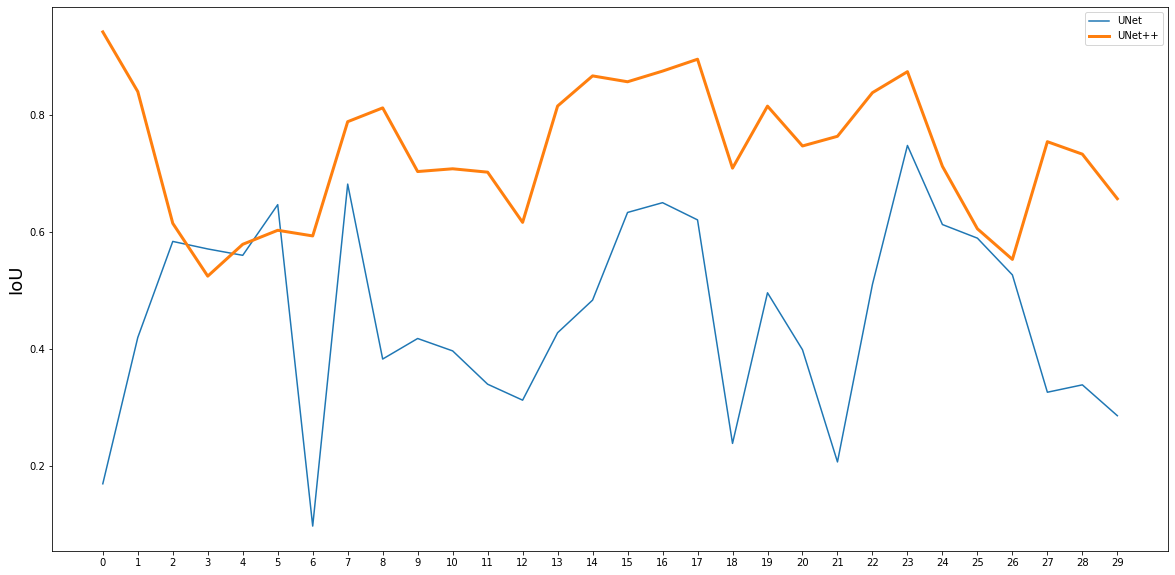

In [60]:
# 그래프로 확인
plt.figure(figsize=(20, 10))
plt.plot(unet, label='UNet')
plt.plot(unet_plus, label='UNet++', linewidth='3')
plt.ylabel('IoU', size=18)
plt.xticks(range(30), range(30))
plt.legend()

이렇게 U-Net과 U-Net++에 대해서 확인할 수 있었다.